# 02 - Data from the Web


In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

In [1]:
from bs4 import BeautifulSoup
import requests
import json
import string
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import itertools
import unicodedata
from textblob.blob import TextBlob

%matplotlib inline

# Task 1 - QS Ranking

### Creation of the dataset

Multiple strategies have been testes in order to find the data used to construct the table on the QS Rankings webpage. We found by opening the Web Inspector on the website the different ressources used by the page. Among them a text file named 'XHR/357051.txt'  was containing the expected ranking with the desired informations. The URL_QS links to this file. We convert it to a DataFrame. From there, we delete the unneccessary columns and keep only the first 200 Universities.

In [2]:
URL_QS = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508497791260'
r = requests.get(URL_QS)
page_body = r.json()
qs_df = pd.DataFrame(page_body['data'])
qs_df = qs_df.drop(['core_id','logo','guide','cc', 'nid', 'stars','score'], axis = 1).head(200)

Additionnal informations needed to be accessed on each university webpage. We used the 'url' column, went to the university page and extracted all the number values found on the webpage. We stored the values we were interested in on new columns. In the cases where there were no/a lack of informations on the webpage, the columns are filed with NaN values.

In [3]:
# Going on each university page for each index of the table

for index_ in range(0, qs_df.shape[0]):
    
    URL_ADD = 'https://www.topuniversities.com' + qs_df.get_value(index_, 'url')
    r = requests.get(URL_ADD)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    # Request all numbers that are displayed on the page, we know their order
    all_numbers = soup.findAll('div', {'class' : 'number'})
    
    # If the page contains no numbers, we will store NaN
    if not all_numbers:
        total_faculty_number = np.nan
        interna_faculty_number = np.nan
        total_students_number = np.nan
        interna_students_number = np.nan
   
    else:    
    # Total Faculty Members
        total_faculty = all_numbers[0]
        total_faculty_number = int(re.sub("[^\\d]",'',str(total_faculty)))
    
    # International Faculty Members
        interna_faculty = all_numbers[1]
        interna_faculty_number = int(re.sub("[^\\d]",'',str(interna_faculty)))
    
    # Total Students
        total_students = all_numbers[2]
        total_students_number = int(re.sub("[^\\d]",'',str(total_students)))  
    
    # International Students
        if all_numbers[3] == all_numbers[0]:
            interna_students_number = np.nan
        else:
            interna_students = all_numbers[3]
            interna_students_number = int(re.sub("[^\\d]",'',str(interna_students)))
    
    # Adding the found values in the columns
    qs_df.set_value(index_, 'Faculty Members - Total', total_faculty_number)
    qs_df.set_value(index_, 'Faculty Members - International', interna_faculty_number)
    qs_df.set_value(index_, 'Nb Students - Total', total_students_number)
    qs_df.set_value(index_, 'Nb Students - International', interna_students_number)

The obtained DataFrame is presented below,

In [4]:
qs_df.head(5)

,country,rank_display,region,title,url,Faculty Members - Total,Faculty Members - International,Nb Students - Total,Nb Students - International
0,United States,1,North America,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,2982.0,1679.0,11067.0,3717.0
1,United States,2,North America,Stanford University,/universities/stanford-university,4285.0,2042.0,15878.0,3611.0
2,United States,3,North America,Harvard University,/universities/harvard-university,4350.0,1311.0,22429.0,5266.0
3,United States,4,North America,California Institute of Technology (Caltech),/universities/california-institute-technology-...,953.0,350.0,2255.0,647.0
4,United Kingdom,5,Europe,University of Cambridge,/universities/university-cambridge,5490.0,2278.0,18770.0,6699.0


### Ratios computation

For the next part of the question, we need to compute two ratios for all the different universities. We define a method ratio that will return the expected value.

In [5]:
# ratio returns a/b if both those values are defined
def ratio(a, b):
    if np.isnan(a)|np.isnan(b)|(b == 0):
        return np.nan
    else:
        return a/b

In [6]:
# apply the ratio functions to all universities
for index, row in qs_df.iterrows():
    if np.isfinite(row['Nb Students - Total']) and np.isfinite(row['Nb Students - International']) or np.isfinite(row['Nb Students - Total']) and np.isfinite(row['Faculty Members - Total']):
        qs_df.loc[index, 'QS Ratio Int. Students'] = round(ratio(row['Nb Students - International'], row['Nb Students - Total']), 2)
        qs_df.loc[index, 'QS Ratio Students/Staff'] = round(ratio(row['Nb Students - Total'], row['Faculty Members - Total']), 2)

In [7]:
# Rename columns of the DataFrame for further processing
qs_df = qs_df.loc[ :, ['title', 'rank_display', 'country', 'region', 'QS Ratio Int. Students', 'QS Ratio Students/Staff' ]]
qs_df = qs_df.rename(index=str, columns={ "title" : "University", "rank_display": "QS rank"});
qs_df.index = np.arange(1, len(qs_df) + 1)
qs_df['QS rank'] = qs_df.index.values.tolist()

# Finding the best universities for each ratio
max_internatio_ratio_index = qs_df['QS Ratio Int. Students'].argmax()
max_internatio_ratio = qs_df['QS Ratio Int. Students'][max_internatio_ratio_index]

max_stud_staff_ratio_index = qs_df['QS Ratio Students/Staff'].argmax()
max_stud_staff_ratio = qs_df['QS Ratio Students/Staff'][max_stud_staff_ratio_index]


print("The university with the biggest ratio of international students is the", \
      qs_df.University[max_internatio_ratio_index],"with a ratio of ", max_internatio_ratio, "\n\n")

print("The university with the biggest ratio between faculty members and students is the", \
      qs_df.University[max_stud_staff_ratio_index],"with a ratio of ", max_stud_staff_ratio, "\n\n")

('The university with the biggest ratio of international students is the', u'London School of Economics and Political Science (LSE)', 'with a ratio of ', 0.68999999999999995, '\n\n')
('The university with the biggest ratio between faculty members and students is the', u'Vienna University of Technology', 'with a ratio of ', 24.760000000000002, '\n\n')


### Plot the results

We are now aggregating the data per countries (top) and by region (bottom).

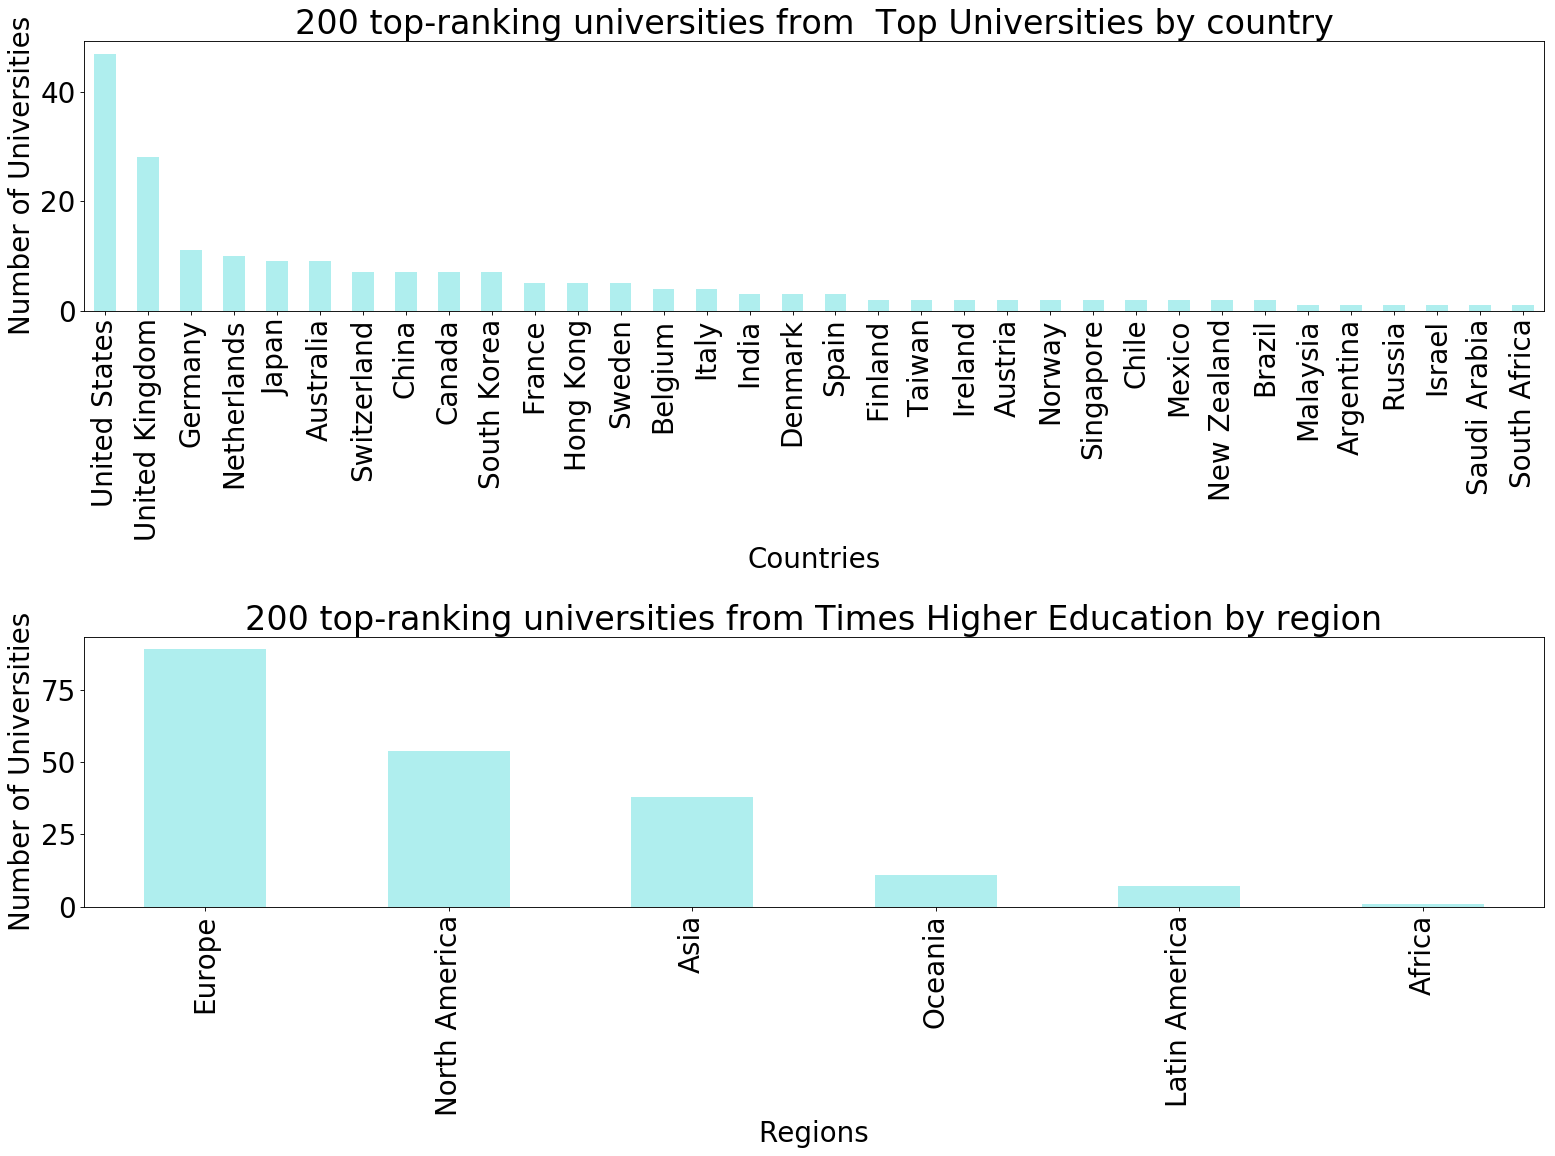

In [8]:
fig = plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

plt.subplot(2,1,1)
embarkedPlot = qs_df['country'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Countries")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from  Top Universities by country')

plt.subplot(2, 1, 2)
embarkedPlot = qs_df['region'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Regions")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from Times Higher Education by region')


fig.tight_layout()

plt.show()

If we look solely to the top-universities by country, one can observe that the United States are dominating the ranking, with the United Kingdom not so far behind. However, if we look at a broader scale with the regions, we can observe that Europe is placing more universities among the top world universities. This can be explained through the sizes of the countries that will vary a lot: the United States are far bigger than any european countries. 

## Task 2 - Times Higher Education Ranking

The same strategy as with the QS ranking was used. This time, less processing of the data was needed to extract the desired DataFrame. There was no need to access a new url for each university, therefore simplifying the code.

In [16]:
URL_THE = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
r = requests.get(URL_THE)
page_body = r.json()
the_df = pd.DataFrame(page_body['data']).head(200)

### Ratios computation

Same strategy to compute the expected ratios. The method ratio is used again. Some small processing of the DataFrame is performed to clean our results and delete the non-necessary informations. For example, the '=' values in case of a tie between university is deleted to only keep track of their position in the list as their rank. The returned DataFrame is presented below.

In [17]:
# Firts we need to remove the '%' symbol from the column "THE % International Students"
# Then we convert the string to int and we do the calculation

the_df['stats_number_students'] = pd.to_numeric(the_df['stats_number_students'].str.replace(',', ''))
the_df['stats_pc_intl_students'] = pd.to_numeric(the_df['stats_pc_intl_students'].str.replace('%', ''))

# Ratios calculation
for index, row in the_df.iterrows():
    the_df.loc[index, 'stats_pc_intl_students'] = round(row['stats_number_students']*row['stats_pc_intl_students']*0.01)
    the_df.loc[index, 'THE Ratio Int. Students'] = round(float(row['stats_pc_intl_students'])/100.0, 2)

# Rename columns for further processing
the_df = the_df.loc[ :, ['name', 'rank', 'location','THE Ratio Int. Students', 'stats_student_staff_ratio']]
the_df = the_df.rename(index=str, columns={ "name" : "University",
                                  "rank": "THE rank", "location": "country",
                                  "stats_student_staff_ratio" : "THE Ratio Students/Staff"
                                 });

# Delete the '=' from the rank and gives them rather their order in the list as rank
the_df.index = np.arange(1, len(the_df) + 1) 
the_df['THE rank'] = the_df.index.values.tolist()

the_df.head(5)

,University,THE rank,country,THE Ratio Int. Students,THE Ratio Students/Staff
1,University of Oxford,1,United Kingdom,0.38,11.2
2,University of Cambridge,2,United Kingdom,0.35,10.9
3,California Institute of Technology,3,United States,0.27,6.5
4,Stanford University,4,United States,0.22,7.5
5,Massachusetts Institute of Technology,5,United States,0.34,8.7


From there, we can find the best Universities for each ratio according to the THE ranking,

In [18]:
max_internatio_ratio_index = the_df['THE Ratio Int. Students'].argmax()
max_internatio_ratio = the_df['THE Ratio Int. Students'][max_internatio_ratio_index]

max_stud_staff_ratio_index = the_df['THE Ratio Students/Staff'].argmax()
max_stud_staff_ratio = the_df['THE Ratio Students/Staff'][max_stud_staff_ratio_index]


print("The university with the biggest International studient ration is the", the_df.University[max_internatio_ratio_index],
      "with a ratio of ", max_internatio_ratio, "\n\n")

print("The university with the biggest studients/staff ratio is the", the_df.University[max_stud_staff_ratio_index],
      "with a ratio of ", max_stud_staff_ratio, "\n\n")

('The university with the biggest International studient ration is the', u'London School of Economics and Political Science', 'with a ratio of ', 0.70999999999999996, '\n\n')
('The university with the biggest studients/staff ratio is the', u'Cornell University', 'with a ratio of ', u'9.8', '\n\n')


### Plot the results

Only the plot for the top-ranking universities per country is presented below. The results doesnt change much between the two rankings, expect from Japan that presents way less universities among the top 200. The region is not depicted below as the value was not appearing in the rankings informations. The best method to find the region knowing the country would be to use the merge that is created in the next question. 

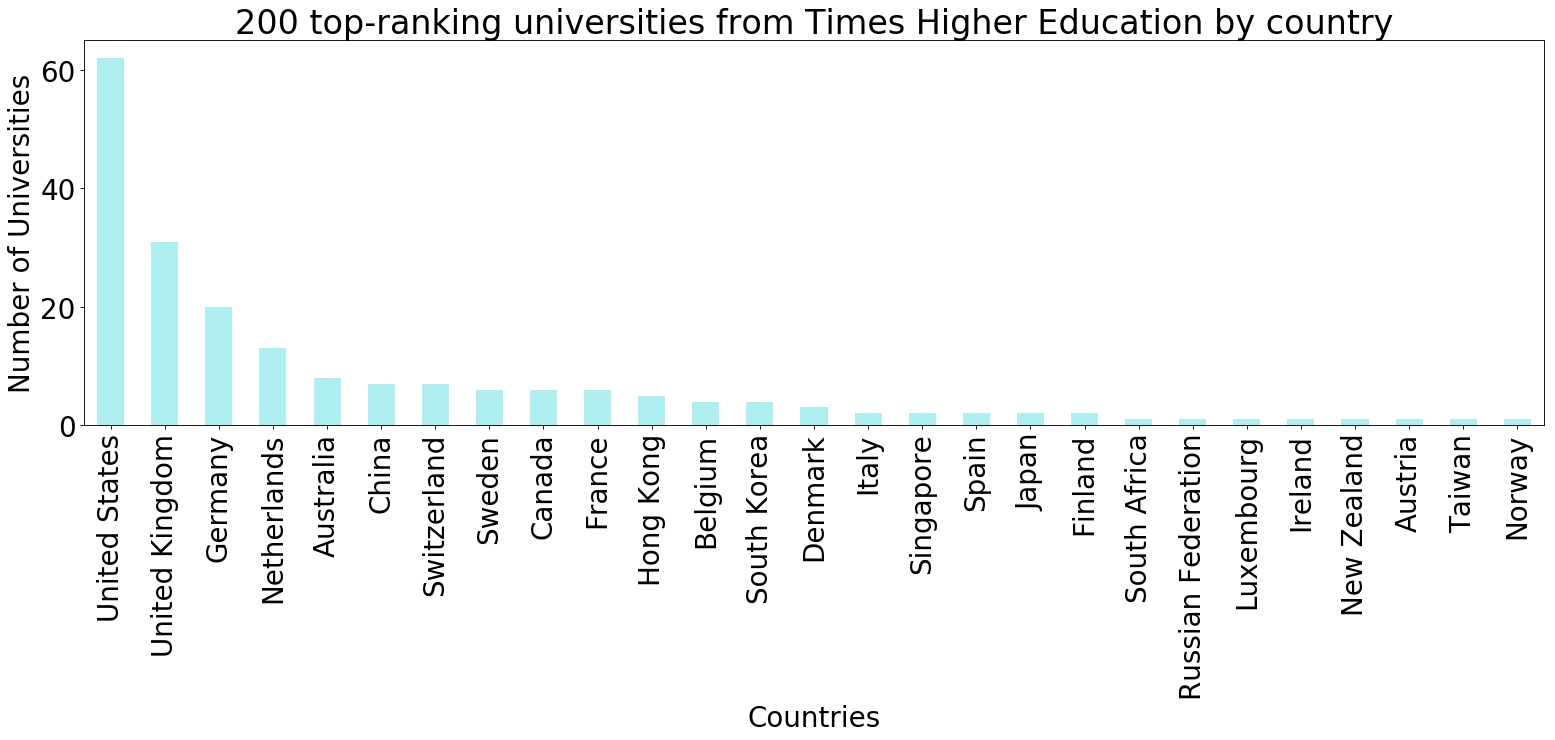

In [21]:
fig2 = plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
embarkedPlot = the_df['country'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Countries")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('200 top-ranking universities from Times Higher Education by country')

#plt.subplot(2, 2, 2)
#embarkedPlot = the_df['region'].value_counts().plot(kind='bar', color='paleturquoise')
#embarkedPlot.set_xlabel("Regions")
#embarkedPlot.set_ylabel("Number of Universities")
#plt.title('FIND TITLE')


fig2.tight_layout()

plt.show()

## Task 3 - Data Merging


For this task, we have to merge the two previously created DataFrames. It will be easier with the pre-processing that was already done to clean the DataFrames and gives them the same column names.

### Clean University Names

To merge both ranking, we take the university names from both ranking, then look at the name in the THE ranking and see if it is contained in a university name in the QS. When this is the case, we rename the university name with the one from the THE.

In [22]:
# Looking if the university name from the THE is contained in a university name from the QS
for index_qs, row_qs in qs_df.iterrows():
     for index_the, row_the in the_df.iterrows():
        if row_the['University'] in row_qs['University'] :
            qs_df.loc[index_qs, 'University'] = row_the['University']

In [23]:
# Method to remove the acronym of a university. For example École Polytechnique Fédérale de Lausanne (EPFL)
def remove_acronyme(column, df):
    for index, row in df.iterrows():
        a = row[column].find('(')
        if a != -1:
            df.loc[index, column] = row[column][:a-1]
remove_acronyme('University', qs_df)     

We also want to remove accents in both rankings.

In [24]:
# Remove accents for QS

for index, row in qs_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in 'fr':
        qs_df.loc[index, 'University'] = ''.join((c for c in unicodedata.normalize('NFD', row['University']) if unicodedata.category(c) != 'Mn'))
        
# Remove accent for THE

for index, row in the_df.iterrows():
    #the_df.loc[index, 'University'] = row['University'].replace('of','')
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in 'fr':
        the_df.loc[index, 'University'] = ''.join((c for c in unicodedata.normalize('NFD', row['University']) if unicodedata.category(c) != 'Mn'))

### Translation

Some university names are displayed in their country's language.We need to translate them in order to make them correspond between the rankings.

In [26]:
for index, row in qs_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in ['de', 'es', 'ms', 'ca', 'la', 'fr']:
        a = en_blob.translate(to='en')
        qs_df.loc[index, 'University'] = str(a)
        
for index, row in the_df.iterrows():
    en_blob = TextBlob(row['University'])
    if en_blob.detect_language() in ['de', 'es', 'ms', 'la', 'fr']:
        a = en_blob.translate(to='en')
        the_df.loc[index, 'University'] = str(a)

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 0: ordinal not in range(128)

### Result DataFrame

In [ ]:
result = pd.merge(qs_df, the_df, how='outer', on='University')

result = result.drop(['country_x'], axis=1)
result = result.rename(index=str, columns={ "country_y" : "Country"});

result = pd.concat([result.filter(like='University'),
                  result.filter(items=['Country', 'region']), result.filter(like='rank'), 
                  result.filter(like='Ratio Int. Students'), result.filter(like='Ratio Students/Staff')],  
                  axis=1,  
                  keys=('University', 'Location', 'Rank','Ratio Int. Students', 'Ratio Students/Staff'))

result = result.rename(index=str, columns={ "QS rank" : "QS", "THE rank" : "THE", 'QS Ratio Int. Students': 'QS',
                                          'THE Ratio Int. Students': 'THE', 'QS Ratio Students/Staff' : 'QS',
                                          'THE Ratio Students/Staff' : 'THE'});

result.to_csv('result.csv')

result.head()

## Task 4 - Correlation

In [ ]:
# We remplace the name of country/region for the plot

countryList = result['Location']['Country'].unique()  # List the different country
countryList = [x for x in countryList if str(x) != 'nan'] # Remove Nan values
countryDict = {k: v for v, k in enumerate(countryList)}   # Transforme to dict

regionList = result['Location']['region'].unique() 
regionList = [x for x in regionList if str(x) != 'nan']
regionDict = {k: v for v, k in enumerate(regionList)}

result_tmp = result.replace({"Location": countryDict}).replace({"Location": regionDict})
result_tmp = result_tmp.replace("No Ratio", np.nan)

In [ ]:
# Plot

plt.figure(figsize=(30, 50), dpi=60, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

plt.subplot(4,1,1)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Ratio Int. Students']['QS'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Ratio Int. Students']['THE'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Ratio Int. Students")
plt.legend(loc='upper right');
plt.title("Ratio International/Total Students in function of the Rank")

plt.subplot(4,1,2)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Ratio Students/Staff']['QS'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Ratio Students/Staff']['THE'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Ratio Students/Staff")
plt.legend(loc='upper right');
plt.title("Ratio Students/Staff in function of the Rank")

plt.figure(figsize=(30,80), dpi= 60, facecolor='w', edgecolor='k')

plt.subplot(4,1,3)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Location']['Country'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Location']['Country'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Country")
plt.legend(loc='upper right');
plt.title("Country in function of the Rank")
plt.yticks(range(0, np.shape(countryList)[0], 1), countryList)


plt.figure(figsize=(30,40), dpi= 60, facecolor='w', edgecolor='k')

plt.subplot(4,1,4)
plt.scatter(result_tmp['Rank']['QS'], result_tmp['Location']['region'], s=200, label='QS')
plt.scatter(result_tmp['Rank']['THE'], result_tmp['Location']['region'], s=200, label='THE')
plt.xlabel("Rank")
plt.ylabel("Region")
plt.legend(loc='upper right');
plt.title("Region in function of the Rank")
plt.yticks(range(0, np.shape(regionList)[0], 1), regionList)

plt.rcParams.update({'font.size': 30})

plt.show()


plt.show()

- North America : Beaucoup d'école bien placé
- Europe : beaucoup plus "spread"
- Autre : osef